# 项目6 像莎士比亚一样写作：循环神经网络
### 项目描述

当我们在理解一句话意思时，孤立的理解这句话的每个词是不够的，需要处理这些词连接起来的整个序列；当我们处理视频的时候，也不能只单独的去分析每一帧，而要分析这些帧连接起来的整个序列。循环神经网络是为了更好地处理时序信息而设计的，它引入状态变量来存储过去的信息，并用其当前的输入共同决定当前的输出。

循环神经网络有着极其广泛的实际应用，如识别一段文字或语音的含义，识别视频的含义等等。本项目任务是通过学习循环神经网络的基本知识，并使用循环神经网络实现的古诗生成器，能够完成古体诗的自动生成。“熟读唐诗三百首，不会作诗也会吟”，让循环神经网络学习几千首唐诗后成为AI诗人。


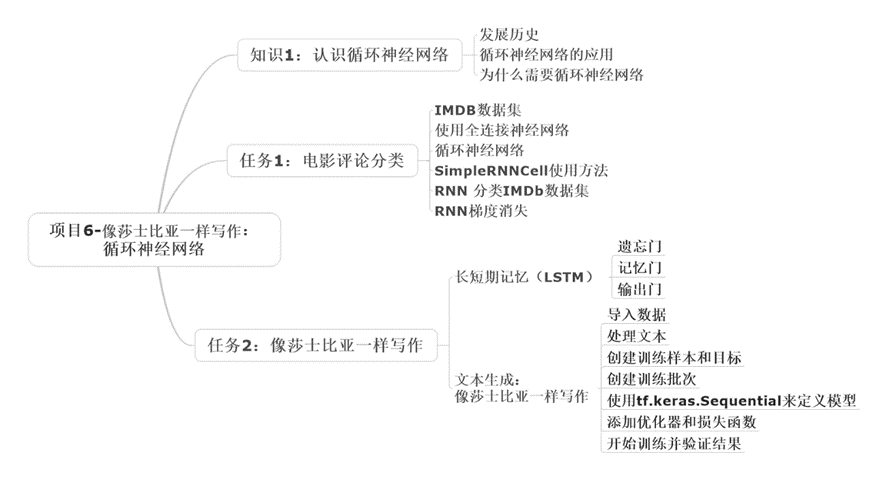

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,optimizers,datasets
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
version = tf.__version__
cpu = tf.config.list_physical_devices('CPU')
gpu = tf.config.list_physical_devices('GPU')
print("tensorflow version:",version,"\nCPU",cpu,"\nGPU",gpu)


# with tf.device('/device:CPU:0'):

tensorflow version: 2.8.0 
CPU [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')] 
GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 6.1 认识循环神经网络简介
传统的机器学习算法依赖于人工提取的特征，图像识别、语言识别以及自然语言处理等问题特征提取困难。基于全连接神经网络的方法存在参数太多，无法利用数据中的时序信息等问题。由于循环神经网络在挖掘数据中的时序信息以及语言信息的特殊能力，使得它在语音识别、机器翻译以及时序分析等方面实现了突破。

### 6.1.1 发展历史

循环神经网络源自于1982年由Saratha Sathasivam提出的霍普菲尔德网络（Hopfield Network），但其因为实现困难而未被应用。1986年，另一位机器学习的泰斗Michael I. Jordan定义了Recurrent的概念，提出Jordan Network。1990年，美国认知科学家Jeffrey L. Elman对Jordan Network进行了简化，并采用BP算法进行训练，便有了如今最简单的包含单个自连接节点的RNN模型。但此时RNN由于梯度消失（Gradient Vanishing）及梯度爆炸（Gradient Exploding）的问题，训练非常困难。

直到1997年，瑞士人工智能研究所的主任Jurgen Schmidhuber提出长短期记忆（LSTM），LSTM使用门控单元及记忆机制大大缓解了早期RNN训练的问题。同样在1997年，Mike Schuster 提出双向RNN模型（Bidirectional RNN）。这两种模型大大改进了早期RNN结构，拓宽了RNN的应用范围，为后续序列建模的发展奠定了基础。此时RNN虽然在一些序列建模任务上取得了不错的效果，但由于计算资源消耗大，后续几年一直没有太大的进展。

2010年，Tomas Mikolov提出了基于RNN的语言模型（RNN LM），并将其用在语音识别任务中，大幅提升了识别精度。Tomas Mikolov在此基础上于2013年提出了大名鼎鼎的word2vec，。word2vec的目标不再专注于建模语言模型，而是如何利用语言模型学习每个单词的语义化向量（distributed representation）。word2vec引发了深度学习在自然语言处理领域的浪潮。

2014年Bengio团队与Google几乎同时提出了seq2seq架构，将RNN用于机器翻译。没过多久，Bengio团队又提出注意力Attention机制，对seq2seq架构进行改进。自此机器翻译全面进入到神经机器翻译（NMT）的时代，NMT不仅过程简单，而且效果要远超统计机器翻译的效果。目前主流的机器翻译系统几乎都采用了神经机器翻译的技术。除此之外，Attention机制也被广泛用于基于深度学习的各种任务中。

2017年，Facebook人工智能实验室提出基于卷积神经网络的seq2seq架构，将RNN替换为带有门控单元的CNN，提升效果的同时大幅加快了模型训练速度。此后不久，Google提出Transformer架构，使用Self-Attention代替原有的RNN及CNN，更进一步降低了模型复杂度。

OpenAI团队提出预训练模型GPT，把LSTM替换为Transformer来训练语言模型，在应用到具体任务时，与之前学习词向量当作特征的方式不同，GPT直接在预训练得到的语言模型最后一层接上Softmax作为任务输出层，然后再对模型进行微调，在多项任务上GPT取得了更好的效果。不久之后，Google提出BERT模型，将GPT中的单向语言模型拓展为双向语言模型（Masked Language Model），并在预训练中引入了sentence prediction任务。BERT模型在11个任务中取得了最好的效果，是深度学习在NLP领域又一个里程碑式的工作。


### 6.1.2 循环神经网络的应用

1. 语言建模和文本生成

给出一个词语序列，试着预测下一个词语的可能性。这在翻译任务中是很有用的，因为最有可能的句子将是可能性最高的单词组成的句子。

2. 机器翻译

将文本内容从一种语言翻译成其他语言使用了一种或几种形式的 RNN。所有日常使用的实用系统都用了某种高级版本的 RNN。

3. 语音识别

基于输入的声波预测语音片段，从而确定词语。

4. 生成图像描述

RNN 一个非常广泛的应用是理解图像中发生了什么，从而做出合理的描述。这是 CNN 和 RNN 相结合的作用。CNN 做图像分割，RNN 用分割后的数据重建描述。这种应用虽然基本，但可能性是无穷的。

5. 视频标记

可以通过一帧一帧地标记视频进行视频搜索。


### 6.1.3 为什么需要循环神经网络

已经有像卷积网络这样表现非常出色的网络了，为什么还需要其他类型的网络呢？

人类在做思考的时候，并不是每次都从一片空白的大脑开始的。比如，在阅读这篇文章的时候，对文章的理解程度都会依赖于之前已经积累的相关知识。人类之所以能够不断进步，一个重要的原因就是不会丢掉之前学到的全部知识而每次重新从空白的大脑开始思考。大脑对知识具有持久性。

为了解释 RNN，首先需要了解序列的相关知识。序列是相互依赖的（有限或无限）数据流，比如时间序列数据、信息性的字符串、对话等。在对话中，一个句子可能有一个意思，但是整体的对话可能又是完全不同的意思。

比如，要完成如下句子的填空：

今天天气特别好，我想去___。

传统神经网络结构由于只能单独的去处理一个个的输入，前一个输入和后一个输入是完全没有关系的，也就是说当传统神经网络看到“特别好”这个词语时，并不会与前面的“天气”进行关联，因而也无法正确理解语义，结果针对这个句子是会生成与上文无关的答案，诸如“书本”，“马路”等。
很明显，这个句子中，前面的信息“天气”“特别好”都会对后面的“我想去”有很大的影响。而 RNN 就能够很好的捕获“天气”“特别好”这种关键信息，当处理到“我想去”时，会结合上文信息生成符合语境的答案，如“玩”，“游玩”等。

所以，传统神经网络在处理时序数据时具有巨大的弊端，即无法利用先前的信息来推断后续的行为。前一个输入和下一个输入之间没有任何关联。所以所有的输出都是独立的。神经网络接受输入，然后基于训练好的模型输出。如果运行了100个不同的输入，它们中的任何一个输出都不会受之前输出的影响。

无论是卷积神经网络，还是人工神经网络，前提假设都是元素之间是相互独立的，输入与输出也是独立的，比如猫和狗。但现实世界中，很多元素都是相互连接的，因此就有了循环神经网络，像人一样拥有记忆的能力，网络的输出依赖于当前的输入和记忆。循环神经网络的提出正是借鉴了人类大脑学习的重要环节，从而来解决了传统神经网络的弊端。循环神经网络允许神经单元包含循环，这样信息可以在不同时刻传输，达到信息持久化的目的。


## 6.2 任务1:电影评论分类

本项目任务根据电影评论的文字内容将其划分为正面(positive)或负面(nagetive)。


### 6.2.1 IMDB数据集 

将使用来源于网络电影数据库的IMDB数据集，它包含50 000条严重两极分化的评论。数据集被分为用于训练的 25000 条评论与用于测试的 25000 条评论，训练集和测试集都包含50%的正面评论和50%的负面评论。

和波士顿房价数据集类似，IMDB数据集也集成在Keras中，同时经过了预处理：电影评论转换成了一系列数字，每个数字代表字典中的一个单词。
首先下载IMDB数据集，IMDB数据集可以在 Tensorflow 数据集处获取。


In [4]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

- 参数 num_words=10000 的意思是仅保留训练数据中前10000个最常出现的单词，低频单词将被舍弃。

- train_data 和 test_data 这两个变量都是评论组成的列表

- 每条评论又是单词索引组成的列表（表示一系列单词）

- 里面的单词数值化，比如‘a’ = 1

- train_labels 和 test_labels 都是 0 和 1 组成的列表，其中 0代表负面，1 代表正面。

打印一些数据来了解数据集的格式。每一个样本都是一个表示电影评论和相应标签的句子。该句子不以任何方式进行预处理。

In [5]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))
print(train_data[0])


Training entries: 25000, labels: 25000
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


train_data中存放了25,000条评论，评论文本被转换为整数值，其中每个整数代表词典中的一个单词。train_labels存放了25,000个标签，是0,1列表。

可以将某条评论迅速解码为英文单词，创建一个辅助函数decode_review来查询一个包含了整数到字符串映射的字典对象。

In [6]:
# 一个映射单词到整数索引的词典
word_index = imdb.get_word_index()

# 保留第一个索引
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
# 调用decode_review函数解码train_data[0]:
decode_review(train_data[0])


1654784/1641221 [==============================] - 1s 1us/step


"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

电影评论可能具有不同的长度。以下代码显示了第一条和第二条评论的中单词数量。

In [7]:
len(train_data[0]), len(train_data[1])

(218, 189)

不能将整数序列直接输入神经网络，整数数组必须在输入神经网络之前转换为张量。可以通过以下两种方式来完成转换：

- 将数组转换为表示单词出现与否的由0和1组成的向量，类似于one-hot编码。例如，序列[3, 5]将转换为一个 10,000 维的向量，该向量除了索引为 3 和 5 的位置是 1 以外，其他都为 0。这种方法需要大量的内存，需要一个大小为 num_words * num_reviews 的矩阵。

- 可以填充数组来保证输入数据具有相同的长度，然后创建一个大小为 max_length * num_reviews 的整型张量。可以使用能够处理此形状数据的嵌入层作为网络中的第一层。
  
将使用 pad_sequences 函数来使长度标准化


In [8]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)


### 6.2.2 使用全连接神经网络

传统的神经网络存在的一个问题，只适用于预先设定的大小。通俗讲就是采用固定的大小的输入并产生固定大小的输出。例如卷积网络，4×4图像为输入，最终指定输出2×2的图像。

循环神经网络专注于处理文本，其输入和输出的长度是可变的，比如，一对一，一对多，多对一，多对多，如图

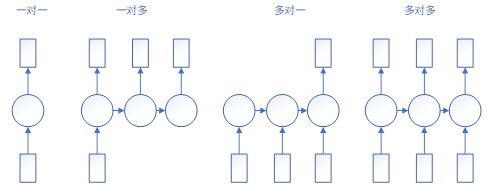

- 一对一形式（One to One） 每一个输入都有对应的输出。

- 多对一形式（Many to One）整个序列只有一个输出，例如文本分类、情感分析等。

- 一对多形式（One to Many）一个输入产出一个时序序列，例如看图说话。

- 多对多形式（Many to Many）不是每一个输入对应一个输出，对应到变成的输出，例如翻译。

能让机器会看懂图像还不够，最好还得能理解人类语言。所谓自然语言处理（Natural Language Processing，NLP），就是让计算机具备处理、理解和运用人类语言的能力。实际上，NLP的任务难度要远大于计算机视觉。以NLP的一个应用案例——机器翻译来分析一下，看看基于深度学习自然语言处理问题是如何被规范为一个从输入到输出的有监督机器学习问题的。

大家都用过机器翻译，谷歌翻译、百度翻译、有道翻译。模型输入是一段待翻译的中文、英文或者是任意国家的文字，总的来说输入是由一个个单词或者文字组成的序列文本。那么作为翻译的结果，输出也是一个个单词或者文字组成的序列文本，只不过换了一种语言，所以在机器翻译这样一个自然语言处理问题中，研究的关键在于如何构建一个深度学习模型来将输入语言转化为输出语言。可以看到它们的输入输出形式都是序列化的。

IMDB数据集有5万条来自网络电影数据库的评论，需要将电影评论分类为：正和负。输入是由一个个单词或者文字组成的序列文本，输出则是一个单独的类别。‘
以下面文件序列为例，预测其情感类型：正面评价或者负面评价。

“我喜欢诺兰”。



从分类的角度看，这是一个简单的二分类问题，可以使用全连接网络来处理这个问题。对于每个词通过net1提取语义特征，再将单词的所有特征合并，通过net2输出序列的类别概率分布。

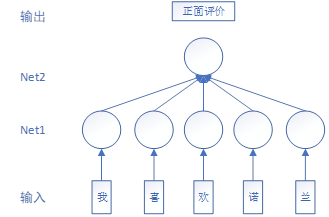

结果表明这种方法并不好，主要是存在下面两个问题：

1.	输入序列数据在不同的例子中可以有不同的长度；

2.	全连接神经网络结果并不能共享从文本不同位置所学习到的特征。

序列是相互依赖的（有限或无限）数据流，比如时间序列数据、信息性的字符串、对话等。在对话中，一个句子可能有一个意思，但是整体的对话可能又是完全不同的意思。全连接神经网络只能单独的处理一个个的输入，前一个输入和后一个输入是完全没有关系的。但现在的任务需要能够更好的处理序列的信息，即前面的输入和后面的输入是有关系的。

当理解一句话意思时，孤立的理解这句话的每个词是不够的，需要处理这些词连接起来的整个序列。如果需要对依赖于先前输入状态（如消息）的序列数据进行操作，或者序列数据可以在输入或输出中，或者同时在输入和输出中，这就是需要循环神经网络。RNN 对之前发生在数据序列中的事是有一定记忆的，这有助于系统获取上下文。理论上讲，RNN 有无限的记忆，这意味着它们有无限回顾的能力。


###  6.2.3循环神经网络

全连接神经网络和卷积神经网络结构都是从输入层到隐藏层再到输出层，层与层之间是全连接或者部分链接，但每层之间的节点是不链接的。循环神经网络的主要用途是处理和预测序列数据，它可以刻画一个序列当前的输出与之前信息的关系，会记忆之前的信息，并利用之前的信息影响后面节点的输出。

循环神经网络的典型结构如图所示，通过隐藏状态来存储之前时间步的信息，有一条单向流动的信息流是从输入单元到达隐藏单元的，与此同时另一条单向流动的信息流从隐藏单元到达输出单元。

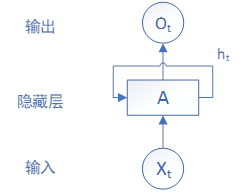

循环神经网络一个重要的概念是时刻，包含输入单元的输入集标记为$ {X_0,X_1,...,X_t,X_{t+1},...}$，而输出单元(Output units)的输出集则被标记为${O_0,O_1,...,O_t,O_{t+1}.,..}$。RNN包含隐藏单元$A$，隐藏单元完成了最为主要的工作。输入单元经过隐藏单元$A$后会输出一个状态变量$h$，也称其位隐藏变量。在某一时刻$t$，隐藏单元$A$读取$t$时刻的输入$X_t$，输出一个状态变量$h_t$，以及输出$O_t$。

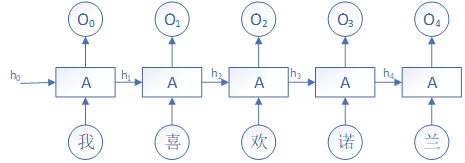

将循环神经网络按时间展开后，可以得到如图所以的结构。这个网络在$t$时刻接收到输入之后，隐藏层的值是$h_t$，输出值是$O_t$。$h_t$与$O_t$的值不仅仅取决于$X_t$，还取决于$h_{t-1}$。

循环神经网络的参数包括隐藏层的权重$W_xh$，$W_hh$和偏差 $bh$，可以用下面的公式来表示循环神经网络的计算方法：

$$ h_t=σ（W_{xh} x_t+W_{hh} h_{t-1}+b）$$

状态变量$h_t$是网络的记忆单元。$h_t$根据当前输入层的输出与上一步隐藏层的状态进行计算，含了前面所有步的隐藏层状态。如图，在$t_0$时刻，输入为“我”，$h_0$此时为初始化状态，通常是全$0$，通过隐藏单元$A$计算后输出$O_0$与$h_1$，由于现在是一个多对一的任务，任务需要预测一条语句所表达的情绪，仅仅需要关系最后一个单词输入后的输出，而不需要知道每个单词输入后的输出，因此$O_0$没有用。在$t_1$时刻，输入为“喜”以及上一次的状态变量$h_1$，通过隐藏单元$A$计算后输出$O_1$与$h_2$。

在传统神经网络中，每一个网络层的参数是不共享的。而在RNN中每次输入，每一层各自都共享参数。每一步都在做相同的事，只是输入不同，因此大大地降低了网络中需要学习的参数。在循环神经网络中，激活函数通常采用tanh函数，可以选择不使用偏差$ bh$来进一步减少参数量。

### 6.2.4 SimpleRNNCell使用方法

SimpleRNNCell类可以理解为RNN中的一个时间步的计算，而RNN则是把多个这样的Cell进行串联起来统一计算。方框表示一个Cell的计算，完整的序列则表示整个RNN的计算，如图所示。

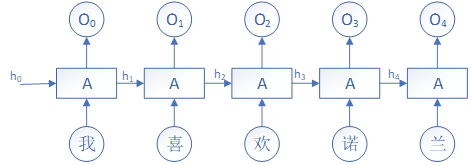

SimpleRNNCell继承自Layer基类，常用方法如下：

- init()：构造方法，主要用于初始化参数

- build()：主要用于初始化网络层中涉及到的权重参数

- call()：用于网络层的参数计算，对输入进行计算，并产生相应地输出

常用参数如下:

- Units： 正整数，输出空间的维度，即隐藏层神经元数量.

- Activation： 激活函数，默认是tanh

- use_bias： Boolean, 是否使用偏置向量.


SimpleRNNCell完成的是隐藏层的计算，即$σ（W_{xh} x_t+W_{hh} h_{t-1}+b）$，仅仅完成了一个时间戳的前向运算。假设输入$X_t$的特征长度为4，隐藏层神经元数量为3，新建一个SimpleRNNCell。

In [9]:
recurrent_cell = tf.keras.layers.SimpleRNNCell(3)
recurrent_cell.build(input_shape=(None,4))
recurrent_cell.trainable_variables


[<tf.Variable 'kernel:0' shape=(4, 3) dtype=float32, numpy=
 array([[ 0.18821943,  0.15854526, -0.8023025 ],
        [-0.33837664, -0.48515925,  0.8829322 ],
        [ 0.33455372,  0.0380404 , -0.8160303 ],
        [-0.38735235, -0.6560986 ,  0.9054028 ]], dtype=float32)>,
 <tf.Variable 'recurrent_kernel:0' shape=(3, 3) dtype=float32, numpy=
 array([[ 0.28365278,  0.9346435 ,  0.21443543],
        [-0.9570532 ,  0.28990245,  0.00240314],
        [-0.05991929, -0.20590776,  0.9767352 ]], dtype=float32)>,
 <tf.Variable 'bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

隐藏层$W_{xh} x_t+W_{hh} h_{t-1}$的计算等价与$x_t$与$h_{t-1}$连接后的矩阵乘以$W_{xh}$与$W_{hh}$连接后的矩阵。trainable_variables参数返回了SimpleRNNCell内部的3个张量。tf.Variable 'kernel:0' shape=(4, 3)即W_xh，tf.Variable 'recurrent_kernel:0' shape=(3, 3)即$W_{hh}$，tf.Variable 'bias:0' shape=(3,)即$b$。

上面的计算过程可以用以下公式表示：

$$ O_t，h_t=SimpleRNNCell(x_t,h_{t-1})$$

SimpleRNNCell类并没有维护状态变量$h_t$，需要用户自行初始化$h_0$，并且记录每个时刻的值。SimpleRNNCell类$O_t$，$h_t$是同一个对象。
假设输入X批量大小为4，序列长度为80，特征长度为100，张量形状表示为[b,seq len,word vec]，shape=(4, 80,100)。隐藏层神经元数量为64，则$O_t$，$h_t$张量形状表示为[b,hdim]，shape=(4, 64)。


In [10]:
x = tf.random.normal([4, 80, 100])
xt = x[:, 0, :]
h0 = tf.zeros([4, 64])
recurrent_cell = tf.keras.layers.SimpleRNNCell(64)
out, h1 = recurrent_cell(xt, h0)
out.shape, h1[0].shape


(TensorShape([4, 64]), TensorShape([64]))

经过一个时间戳的计算后，输出O与状态变量h的形状都是(4, 64)。打印两者id，可以看到也是一致的。

In [11]:
print(id(out),id(h1[0]))

2623639791216 2623639791920


实际编程时没有必要自己维护状态变量，可以使用RNN类

In [12]:
x = tf.random.normal([4, 80, 100])
rnn = tf.keras.layers.RNN(tf.keras.layers.SimpleRNNCell(64))

rnn = tf.keras.layers.RNN(
    tf.keras.layers.SimpleRNNCell(64),
    return_sequences=True,
    return_state=True)
whole_sequence_output, final_state = rnn(x)
print(whole_sequence_output.shape)
print(final_state.shape)


(4, 80, 64)
(4, 64)


### 6.2.5 RNN 分类IMDb数据集

下面将实现一个基于字符级别的循环神经网络的语言模型，并用它来挑战IMDb 数据集的情感分类问题。首先导入Keras，并通过Keras提供的数据集工具加载IMDb数据集。


设置字典大小，假设字典中不同字符的数量为10000，并设置训练集和测试集。

In [13]:
imdb = keras.datasets.imdb
vocabulary_size = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = vocabulary_size)
print('Loaded dataset with {} training samples, {} test samples'.format(len(x_train), len(x_test))) 


Loaded dataset with 25000 training samples, 25000 test samples


训练集和测试集都是25000条影评，其中评分小于5的用户评价标注为0，即消极。

In [14]:
print(x_train.shape,y_train.shape)
print('---review---')
print(x_train[0])
print('---label---')
print(y_train[0])


(25000,) (25000,)
---review---
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
---label---
1


x_train与x_test都是长度为25000的向量，数组的每个元素是不定长的list，保存了数字编码的句子，x_train[0]为训练集的第一个句子，共有218个单词。可以通过查看它的编码表来获得编码方案。

可以使用imdb.get_word_index()返回的字典将评论映射回原始单词。


In [15]:
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print('---review with words---')
print([id2word.get(i, ' ') for i in x_train[0]])
print('---length---')
print(len(x_train[0]))
print('---label---')
print(y_train[0])


---review with words---
['the', 'as', 'you', 'with', 'out', 'themselves', 'powerful', 'lets', 'loves', 'their', 'becomes', 'reaching', 'had', 'journalist', 'of', 'lot', 'from', 'anyone', 'to', 'have', 'after', 'out', 'atmosphere', 'never', 'more', 'room', 'and', 'it', 'so', 'heart', 'shows', 'to', 'years', 'of', 'every', 'never', 'going', 'and', 'help', 'moments', 'or', 'of', 'every', 'chest', 'visual', 'movie', 'except', 'her', 'was', 'several', 'of', 'enough', 'more', 'with', 'is', 'now', 'current', 'film', 'as', 'you', 'of', 'mine', 'potentially', 'unfortunately', 'of', 'you', 'than', 'him', 'that', 'with', 'out', 'themselves', 'her', 'get', 'for', 'was', 'camp', 'of', 'you', 'movie', 'sometimes', 'movie', 'that', 'with', 'scary', 'but', 'and', 'to', 'story', 'wonderful', 'that', 'in', 'seeing', 'in', 'character', 'to', 'of', '70s', 'musicians', 'with', 'heart', 'had', 'shadows', 'they', 'of', 'here', 'that', 'with', 'her', 'serious', 'to', 'have', 'does', 'when', 'from', 'why', 'wh

打印最长评论长度和最短评论长度。

In [17]:
print('Maximum review length: {}'.format(
len(max((x_train + x_test), key=len))))
print('Minimum review length: {}'.format(
len(min((x_test + x_test), key=len))))


Maximum review length: 2697
Minimum review length: 14


为了将这些数据输入到RNN中，输入的所有评论长度必须相同。下面将截断较长的评论，并以空值（0）填充较短的评论，从而将最大评论长度限制为max_words。 可以使用Keras中的pad_sequences()函数来完成此操作。将max_words设置为500。

In [18]:
max_words = 500
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_words)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_words)


下面设计用于情感分析的RNN模型，使用tf.keras.Sequential来构建模型架构。 需要使用Embedding层，2个SimpleRNN层，最后通过Dense层分类。输入序列通过Embedding层完成词向量编码，循环通过2个SimpleRNN层，提取语义特征，取最后一层的最后时间戳的状态输出送入Dense层分类，经过激活函数后得到输出概率。

输入是最大长度max_words的单词序列，输出是二进制情感标签（0或1）。


In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocabulary_size, 100),
    tf.keras.layers.SimpleRNN(64,return_sequences=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(1)
])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 64)          10560     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,018,881
Trainable params: 1,018,881
Non-trainable params: 0
_________________________________________________________________
None


模型共有1,018,881个参数。

使用Keras的compile&fit方法来训练网络，优化器使用Adam，学习率设置为0.001，误差函数选用二分类的交叉熵损失函数BinaryCrossentropy，测试指标采用准确率。


In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


编译后就可以开始训练了，设置Epoch为20、Batch size为64。 

In [ ]:
batch_size = 64
num_epochs = 20
x_valid, y_valid = x_train[:batch_size], y_train[:batch_size]
x_train2, y_train2 = x_train[batch_size:], y_train[batch_size:]
history = model.fit(x_train2, y_train2, validation_data=(x_valid, y_valid), batch_size=batch_size, epochs=num_epochs)


Epoch 1/20
390/390 [==============================] - 304s 777ms/step - loss: 0.6337 - accuracy: 0.5802 - val_loss: 0.2834 - val_accuracy: 0.8906
Epoch 2/20
390/390 [==============================] - 297s 763ms/step - loss: 0.3255 - accuracy: 0.8626 - val_loss: 0.2354 - val_accuracy: 0.9375
Epoch 3/20
390/390 [==============================] - 295s 757ms/step - loss: 0.2164 - accuracy: 0.9170 - val_loss: 0.2473 - val_accuracy: 0.8906
Epoch 4/20
390/390 [==============================] - 298s 765ms/step - loss: 0.1629 - accuracy: 0.9419 - val_loss: 0.3686 - val_accuracy: 0.8750
Epoch 5/20
390/390 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9601

网络共训练20个Epoch，训练好模型后，使用测试数据验证其准确率。

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))


导入 matplotlib 并创建一个辅助函数来绘制计算图。

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

plot_graphs(history,'accuracy')
plot_graphs(history,'loss')


在训练过程中画出accuracy 和loss曲线能够更直观的观察网络训练的状态，以便更好的优化网络的训练

##  6.3 任务2:像莎士比亚一样写作

“有个星星在跳舞，在那之下我出生了。”

威廉·莎士比亚（William Shakespeare），《 无事生非》

可以让AI像莎士比亚一样写作吗？

语言模型中一句话通常包含几十个词，这意味着RNN的层数需要几十层，这会带来梯度消失问题与长期依赖问题。RNN由于这两大问题在实际应用中很少使用，而LSTM通过门机制完美的解决了这两个问题。


### 6.3.1 长短期记忆（LSTM）

基本RNN单元可以对具有时间序列的数据建模，但当输入时间序列太长时，RNN模型中较早时刻的隐藏层状态很难一直传递下去。补救这一问题的措施是1997年首先被Sepp Hochreiter和Jurgen Schmidhuber提出的长短期记忆（Long Short Term，LSTM）模型。在这个模型中，常规的神经元，即一个将S型激活应用于其输入线性组合的单位，被存储单元所代替。LSTM中引入了三个门，输入门（input gate）、遗忘门（forget gate）和输出门（output gate），以及与隐藏状态形状相同的细胞状态（cell state），从而记录额外的信息。

长短期记忆（Long Short Term Memory，LSTM）网络是一种特殊的RNN模型，其特殊的结构设计使得它可以避免长期依赖问题，记住很早时刻的信息是LSTM的默认行为，而不需要专门为此付出很大代价。LSTM结构有点复杂，接下来会详细解释。

LSTM引入了细胞状态C_t ，用来保存当前LSTM的状态信息并传递到下一时刻的LSTM中。当前的LSTM接收来自上一个时刻的细胞状态$C_{t-1}$ ，并与当前LSTM接收的信号输入$x_t$共同作用产生当前LSTM的细胞状态 $C_t$，如图所示。

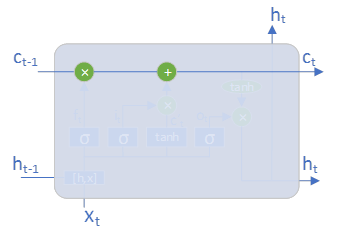

LSTM采用专门设计的“门”来引入或者去除细胞状态中的信息。门是一种让信息选择性通过的方法。有的门跟信号处理中的滤波器有点类似，允许信号部分通过或者通过时被门加工了。有的门也跟数字电路中的逻辑门类似，允许信号通过或者不通过。这里所采用的门包含一个激活函数为sigmod的全连接层和一个按位的乘法操作构成。

LSTM主要包括三个不同的门结构：遗忘门、记忆门和输出门。这三个门用来控制LSTM的信息保留和传递。

遗忘门是用来“忘记”信息的。在LSTM的使用过程中，有一些信息不是必要的，因此遗忘门的作用就是用来选择这些信息并“忘记”它们。遗忘门决定了细胞状态$C_{t-1}$ 中的哪些信息将被遗忘。遗忘门的工作原理如图

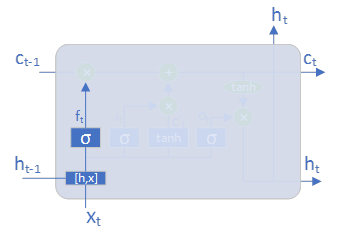

遗忘门由一个激活函数为sigmod的全连接层和一个按位乘操作构成。全连接层参数为$W_f$  $b_f$ ，输入为t时刻的$x_t$ 和$t-1$时刻LSTM的上一个输出信号$h_{t-1}$，这两个信号输入到全连接层中，然后输出信号$f_t$，$f_t$是一个0到1之间的数值(1 表示完全保留，0 表示完全舍弃)，并与$C_{t-1}$相乘来决定$C_{t-1}$中的哪些信息将被保留，哪些信息将被舍弃。
$$ f_t=σ(W_f×[h_{t-1},x_t ]+b_f)$$

记忆门由输入门$i_t$与候选记忆细胞$C'_t$和一个按位乘操作构成。记忆门的作用与遗忘门相反，它将决定新输入的信息$x_t$和 $h_{t-1}$中哪些信息将被保留。

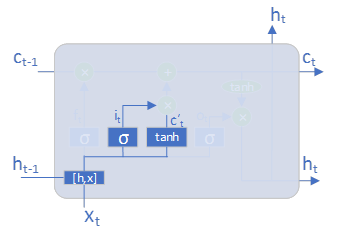


输入门是激活函数为sigmod的全连接层，网络参数为$W_i$  $b_i$，候选记忆细胞是激活函数为tanh的全连接层，网络参数为为$W_c$  $b_c$，如图所示。
$i_t=σ(W_i×[h_{t-1},x_t ]+b_i)$  输入门
$C'_t=tanh(W_C×[h_{t-1},x_t ]+b_C)$ 候选记忆细胞

输入门与遗忘门一样，它接收 $x_t$和 $h_{t-1}$作为输入，然后输出一个0到1之间的数值$i_t$来决定哪些信息需要被更新。

候选记忆细胞的作用是将输入的$x_t$和 $h_{t-1}$整合，然后通过一个全连接层来创建一个新的状态候选向量$C'_t$ ，$C'_t$的值范围在-1到1之间。

记忆门的输出由输入门与候选记忆细胞的输出决定，$i_t$与 $C'_t$相乘来选择哪些信息将被新加入到$t$时刻的细胞状态$C_t$中。

有了遗忘门和记忆门，我们就可以更新细胞状态$C_t$了。

$$C_t=f_t×C_{t-1}+i_t×C'_t$$
  

输出门就是将$t-1$时刻传递过来并经过了前面遗忘门与记忆门选择后的细胞状态$C_{t-1}$， 与t-1时刻的输出信号$h_{t-1}$和$t$时刻的输入信号$x_t$整合到一起作为当前时刻的输出信号。

$$o_t=σ(W_o×[h_{t-1},x_t ]+b_o)$$
$$h_t=o_t×tanh⁡(C_t)$$

$ x_t$和$h_{t-1}$经过一个输出门，输出门是是激活函数为sigmod的全连接层，网络参数为$W_o$  $b_o$，输出一个 0到1之间的数值$o_t$。

$C_t$经过tanh函数得到一个在-1到1之间的数值，并与$o_t$相乘得到输出信号$h_t$ ，同时$h_t$ 也作为下一个时刻的输入信号传递到下一阶段。


### 6.3.2 文本生成：像莎士比亚一样写作

可以让AI像莎士比亚一样写作吗？如果是这样，它能为剧中的每个角色产生出有意义的文字吗？ 在AI情节中，戴斯蒙达娜会遇到李尔国王，这会引发奥赛罗的嫉妒吗？ 悲剧胜过喜剧吗？ 每个角色会保持与原始戏剧相同的说话风格吗？ 核心思想非常简单：以莎士比亚写的真实文本作为输入，并输入到即将要训练的神经网络模型中，然后用训练好的模型来生成新文本，这些文本看起来像是英国最伟大的作家所写的。


1. 导入数据

导入TensorFlow和其他相关库，下载莎士比亚数据集。


In [ ]:
import os
import time

path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')


查看文本长度与内容。

In [ ]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# 文本长度是指文本中的字符个数
print ('Length of text: {} characters'.format(len(text)))


查看文本中的前 250 个字符

In [ ]:
print(text[:250])

2. 处理文本

在训练之前需要将字符串映射到数字表示值。即创建两个对照表：一个用于将字符映射到数字，另一个用于将数字映射到字符。


In [ ]:
# 文本中的非重复字符
vocab = sorted(set(text))
# 创建从非重复字符到索引的映射
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
text_as_int = np.array([char2idx[c] for c in text])

print ('{} unique characters'.format(len(vocab)))

每个字符都有一个对应的整数表示值。打印从 0 到 len(unique) 的索引映射字符。

In [ ]:
print('{')
for char,_ in zip(char2idx, range(20)):
print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')


In [ ]:
# 显示文本首 13 个字符的整数映射
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))


模型需要执行的任务是给定一个字符或者一个字符序列，预测下一个最可能出现的字符是什么？输入是字符序列形式的大量文本，训练任务是学习在给定先前字符序列的情况下如何预测下一个字符，即字符级语言模型。

3. 创建训练样本和目标

将文本划分为训练样本和训练目标。每个训练样本都包含从文本中选取的 seq_length 个字符。相应的目标也包含相同长度的文本，但是将所选的字符序列向右顺移一个字符。将文本拆分成文本块，每个块的长度为 seq_length+1 个字符。例如，假设 seq_length 为 4，文本为“Hello”，则可以将“Hell”创建为训练样本，将“ello”创建为目标。


In [ ]:
# 设定每个输入句子长度的最大值
seq_length = 100
examples_per_epoch = len(text)//seq_length
# 创建训练样本 / 目标
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
for i in char_dataset.take(5):
  print(idx2char[i.numpy()])


使用batch方法可以轻松把单个字符转换为所需长度的序列。

In [ ]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))


对于每个序列，使用 map 方法先复制再顺移，以创建输入文本和目标文本。map 方法可以将一个简单的函数应用到每一个批次 （batch）。打印第一批样本的输入与目标值。

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text
dataset = sequences.map(split_input_target)
#打印第一批样本的输入与目标值
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))


4. 创建训练批次

使用 tf.data 将文本拆分为可管理的序列，在把这些数据输送至模型之前，需要将数据重新排列（shuffle）并打包为批次。


In [ ]:
# 批大小
BATCH_SIZE = 64
# 设定缓冲区大小，以重新排列数据集
# （tf.data可以处理无限序列，不会在内存中重新排列，它维持一个缓冲区，在缓冲区重新排列元素。） 
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset


5. 构建模型

使用tf.keras.Sequential来定义模型。使用三个层来定义模型：

- tf.keras.layers.Embedding：嵌入层（输入层）。一个可训练的对照表，它会将每个字符的数字映射到具有 embedding_dim 个维度的高维度向量；

- tf.keras.layers. LSTM： LSTM 层：一种层大小等于单位数(units = rnn_units)的 RNN。

- tf.keras.layers.Dense：密集层（输出层），带有vocab_size个单元输出。


In [ ]:
# 词集的长度
vocab_size = len(vocab)
# 嵌入的维度
embedding_dim = 256
# RNN 的单元数量
rnn_units = 1024
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
   tf.keras.layers.LSTM(128, dropout=0.5, return_sequences=True),
    # 第二个LSTM层，返回序列作为下一层的输入
    tf.keras.layers.LSTM(128, dropout=0.5, return_sequences=True),
    # 对每一个时间点的输出都做softmax，预测下一个词的概率
    tf.keras.layers.Dense(vocab_size)
  ])
  return model
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)
model.summary()


6. 添加优化器和损失函数

使用标准的 tf.keras.losses.sparse_categorical_crossentropy 损失函数。因为模型返回逻辑回归，所以需要设定命令行参数 from_logits。


In [ ]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
model.compile(optimizer='adam', loss=loss)


7. 开始训练

为了使训练时间合理，使用10个周期来训练模型。


In [ ]:
# 检查点保存至的目录
checkpoint_dir = './training_checkpoints'
# 检查点的文件名
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)
history = model.fit(dataset, epochs=10, callbacks=[checkpoint_callback])


8. 生成文本

由于RNN状态从时间步长传递到时间步的方式，模型一旦构建就只接受固定大小的批次数据。要使用不同的 batch_size 运行模型，需要重建模型并从检查点恢复权重。
首先加载最新的检查点。


In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))


编写def generate_text(model, start_string)函数，完成文本生成功能。设置起始字符串，初始化 RNN 状态并设置要生成的字符个数。用起始字符串和 RNN 状态，获取下一个字符的预测分布。然后用分类分布计算预测字符的索引，把这个预测字符当作模型的下一个输入。

模型返回的 RNN 状态被输送回模型。现在，模型有更多上下文可以学习，而非只有一个字符。在预测出下一个字符后，更改过的 RNN 状态被再次输送回模型。模型就是这样，通过不断从前面预测的字符获得更多上下文，进行学习。

为生成文本，模型的输出被输送回模型作为输入。查看生成的文本，会发现这个模型知道什么时候使用大写字母，什么时候分段，而且模仿出了莎士比亚式的词汇。由于训练的周期小，模型尚未学会生成连贯的句子。


In [ ]:
def generate_text(model, start_string):
  # 评估步骤（用学习过的模型生成文本）

  # 要生成的字符个数
  num_generate = 1000

  # 将起始字符串转换为数字（向量化）
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # 空字符串用于存储结果
  text_generated = []

  # 低温度会生成更可预测的文本
  # 较高温度会生成更令人惊讶的文本
  # 可以通过试验以找到最好的设定
  temperature = 1.0

  # 这里批大小为 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # 删除批次的维度
      predictions = tf.squeeze(predictions, 0)

      # 用分类分布预测模型返回的字符
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # 把预测字符和前面的隐藏状态一起传递给模型作为下一个输入
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))


In [ ]:
print(generate_text(model, start_string=u"ROMEO: "))

虽然有些句子符合语法规则，但是大多数句子没有意义。这个模型尚未学习到单词的含义，但请考虑以下几点：

此模型是基于字符的。训练开始时，模型不知道如何拼写一个英文单词，甚至不知道单词是文本的一个单位。

输出文本的结构类似于剧本，文本块通常以角色名字开始，而且角色名字采用全大写字母。

此模型由小批次（batch）文本训练而成（每批 100 个字符）。此模型能生成更长的文本序列，并且结构连贯。若想改进结果，最简单的方式是增加训练周期EPOCHS为30。
可以测试使用不同的起始字符串，或者尝试增加另一个 RNN 层以提高模型的准确率。


## 拓展项目

清华大学实验室开发的作诗机器人「九歌」亮相央视黄金档节目《机智过人》。它与三位人类检验员一起作诗，由48位投票团成员判断哪首为机器人所做。结果「九歌」成功混淆视听，先后淘汰了北大陈更与武大李四维。

华为也推出了一款来自华为诺亚方舟实验室新推出的写诗AI“乐府”，其不仅能写诗、作词，而且还能写藏头诗。

生成中国的古诗词与自由生成文本不同，通常需要满足内容和形式两个方面的要求。中国的古诗词有各种各样的形式，比如五律、七律、五绝、七绝、满江红、西江月、水调歌头等各种词牌以及对联，每一种都有相应的押韵、平仄、字数、对仗等规定；内容方面，一首诗要围绕着一个主题展开，同时还要保证内容的连贯性，它的要求相对而言是比较复杂的。

本项目任务要求，使用循环神经网络实现的古诗生成器，能够完成古体诗的自动生成，即实现一个AI诗人。

训练数据集可以使用chinese-poetry，它是最全中文诗歌古典文集数据库，最全的中华古典文集数据库，包含 5.5 万首唐诗、26 万首宋诗、2.1 万首宋词和其他古典文集。诗人包括唐宋两朝近 1.4 万古诗人，和两宋时期 1.5 千古词人。网站提供了用json格式保存的数据集，选择诗句内容提取出来保存在文件poetry.txt中，共四万首唐诗作为训练集。具体步骤如下：

1.	文本预处理，需对四万首唐诗文件进行预处理
2.	生成数据集
3.	构建模型
4.	训练与测试模型


In [ ]:
import math
import re
import numpy as np
import tensorflow as tf
from collections import Counter

In [ ]:
# 如果使用GPU训练，设置memory_growth
gpu=tf.config.experimental.list_physical_devices('GPU')
for gp in gpu:
    tf.config.experimental.set_memory_growth(gp,True)

In [ ]:
# 数据路径
poetry_file  = 'poetry.txt'

# 加载数据集
with open(poetry_file, 'r', encoding='utf-8') as f:
    lines = f.readlines()
    # 将冒号统一成相同格式
    lines = [line.replace('：', ':') for line in lines]

In [ ]:
# 禁用词，包含如下字符的唐诗将被忽略
disallowed_words = ['（', '）', '(', ')', '__', '《', '》', '【', '】', '[', ']']   
# 句子最大长度
max_len = 64

# 数据集列表
poetry = []
# 逐行处理读取到的数据
for line in lines:
    if line.count(':') != 1:             # 有且只能有一个冒号用来分割标题
        continue
    __, last_part = line.split(':')      # 后半部分不能包含禁止词
    ignore_flag = False
    for dis_word in disallowed_words:
        if dis_word in last_part:
            ignore_flag = True
            break
    if ignore_flag:
        continue
    if len(last_part) > max_len - 2:     # 长度不能超过最大长度
        continue
    poetry.append(last_part.replace('\n', ''))

In [ ]:
min_word_frequency = 8

# 统计词频，利用Counter可以直接按单个字符进行统计词频
counter = Counter()
for line in poetry:
    counter.update(line)
# 过滤掉低频词
_tokens = [(token, count) for token, count in counter.items() if count >= min_word_frequency]
# 按词频排序
_tokens = sorted(_tokens, key=lambda x: -x[1])
# 去掉词频，只保留词列表
_tokens = [token for token, count in _tokens]

# 补上特殊词标记：填充字符标记、未知词标记、开始标记、结束标记
_tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]'] + _tokens
# 映射: 词 -> 编号
word_idx = dict(zip(_tokens, range(len(_tokens))))

In [ ]:
print('{')
for char,_ in zip(word_idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), word_idx[char]))
print('  ...\n}')

In [ ]:
class Tokenizer:
    def __init__(self, word2idx):
        self.word2idx  = word2idx               # 词->编号的映射
        self.idx2word = {value: key for key, value in self.word2idx.items()}   # 编号->词的映射
        self.vocab = len(self.word2idx)      # 词汇表大小
    
    #给定一个编号，查找词汇表中对应的词, token_id: 带查找词的编号 ，返回值为对应的词  例如： 18 -> '月'
    def id_to_token(self, token_id):
        return self.idx2word[token_id]

    #给定一个词，查找它在词汇表中的编号,未找到则返回低频词[UNK]的编号,token: 带查找编号的词,返回值为词的编号。例如： '月'-> 18 
    def token_to_id(self, token):
        return self.word2idx.get(token, self.word2idx['[UNK]'])
    #给定一个字符串s，在头尾分别加上标记开始和结束的特殊字符，并将它转成对应的编号序列
    def encode(self, tokens):
        token_ids = [self.token_to_id('[CLS]'), ]         # 加上开始标记
        for token in tokens:                              # 加入字符串编号序列
            token_ids.append(self.token_to_id(token))
        token_ids.append(self.token_to_id('[SEP]'))        # 加上结束标记
        return token_ids
    # 给定一个编号序列，将它解码成字符串
    def decode(self, token_ids):
        spec_tokens = {'[CLS]', '[SEP]'}            # 起止标记字符特殊处理
        tokens = []                                 # 保存解码出的字符的list
        for token_id in token_ids:
            token = self.id_to_token(token_id)
            if token in spec_tokens:
                continue
            tokens.append(token)
        return ''.join(tokens)                      

In [ ]:
# 使用词典重新建立分词器
tokenizer = Tokenizer(word_idx)
# 混洗数据
np.random.shuffle(poetry)



In [ ]:
batch_size = 16
class PoetryDataSet:
    def __init__(self, data, random=False):
        self.data = data                # 数据集
        self.batch_size = batch_size     # batch size
        self.steps = int(math.floor(len(self.data) / self.batch_size))        # 每个epoch迭代的步数
        self.random = random         # 每个epoch开始时是否随机排序
    #将序列截断或补齐为相同长度。 data: 待填充数据   length: 填充后的长度
    def sequence_padding(self, data, length=None, padding=None):
        if length is None:                    # 计算填充长度
            length = max(map(len, data))
        if padding is None:                   # 计算填充数据
            padding = tokenizer.token_to_id('[PAD]')
        outputs = []                     # 开始填充
        for line in data:
            padding_length = length - len(line)
            if padding_length > 0:                    # 不足就进行填充
                outputs.append(np.concatenate([line, [padding] * padding_length]))
            else:                                      # 超过就进行截断
                outputs.append(line[:length]) 
        return np.array(outputs)

    def __len__(self):
        return self.steps

    def __iter__(self):
        total = len(self.data)
        if self.random:                             # 是否随机排序
            np.random.shuffle(self.data)
        # 迭代一个epoch，每次yield一个batch
        for start in range(0, total, self.batch_size):
            end = min(start + self.batch_size, total)
            batch_data = []
            # 逐一对古诗进行编码
            for single_data in self.data[start:end]:
                batch_data.append(tokenizer.encode(single_data))
            # 填充为相同长度
            batch_data = self.sequence_padding(batch_data)
            # yield x,y
            yield batch_data[:, :-1], tf.one_hot(batch_data[:, 1:], tokenizer.vocab)
            del batch_data

    def for_fit(self):
        # 死循环，当数据训练一个epoch之后，重新迭代数据
        while True:
            # 委托生成器
            yield from self.__iter__()

In [ ]:
# 构建模型
model = tf.keras.Sequential([
    # 不定长度的输入
    tf.keras.layers.Input((None,)),
    # 词嵌入层
    tf.keras.layers.Embedding(input_dim=tokenizer.vocab, output_dim=128),
    # 第一个LSTM层，返回序列作为下一层的输入
    tf.keras.layers.LSTM(128, dropout=0.5, return_sequences=True),
    # 第二个LSTM层，返回序列作为下一层的输入
    tf.keras.layers.LSTM(128, dropout=0.5, return_sequences=True),
    # 对每一个时间点的输出都做softmax，预测下一个词的概率
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(tokenizer.vocab, activation='softmax')),
])

# 查看模型结构
model.summary()
# 配置优化器和损失函数
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.categorical_crossentropy)


In [ ]:
#随机生成一首诗,tokenizer: 分词器 model: 用于生成古诗的模型
def generate_random_poetry(tokenizer, model, s=''):
    token_ids = tokenizer.encode(s)              # 将初始字符串转成token
    token_ids = token_ids[:-1]                   # 去掉结束标记[SEP]
    while len(token_ids) < max_len:
        # 进行预测，只保留第一个样例（我们输入的样例数只有1）的、最后一个token的预测的、不包含[PAD][UNK][CLS]的概率分布
        _probas = model.predict([token_ids, ])[0, -1, 3:]
        # print(_probas)
        # 按照出现概率，对所有token倒序排列
        p_args = _probas.argsort()[::-1][:100]
        # 排列后的概率顺序
        p = _probas[p_args]
        # 先对概率归一
        p = p / sum(p)
        # 再按照预测出的概率，随机选择一个词作为预测结果
        target_index = np.random.choice(len(p), p=p)
        target = p_args[target_index] + 3
        # 保存
        token_ids.append(target)
        if target == 3:
            break
    return tokenizer.decode(token_ids)

In [ ]:
class Evaluate(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.lowest = 1e10                      # 给loss赋一个较大的初始值

    def on_epoch_end(self, epoch, logs=None):
        if logs['loss'] <= self.lowest:                # 在每个epoch训练完成后调用 ,如果当前loss更低，就保存当前模型参数
            self.lowest = logs['loss']
            model.save("./rnn_model.h5")
        print()
        for i in range(1):
            print(generate_random_poetry(tokenizer, model))


# 创建数据集
data_generator = PoetryDataSet(poetry, random=True)
# 开始训练
model.fit(data_generator.for_fit(), steps_per_epoch=data_generator.steps, epochs=10,
                    callbacks=[Evaluate()])


In [ ]:
# 加载模型
model = tf.keras.models.load_model("rnn_model.h5")

In [ ]:
generate_random_poetry(tokenizer, model, s='床前明月光')